In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch.unitroot import ADF, PhillipsPerron
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [2]:
household_power_consumption = pd.read_csv("household_power_consumption.txt", sep=';',
                                                parse_dates={'DateTime' : ['Date', 'Time']}, 
                                                index_col=["DateTime"],
                                                dayfirst=True,
                                                low_memory=False,
                                                na_values=['nan','?'])


In [3]:
household_power_consumption = household_power_consumption[household_power_consumption.index > "2006-12-26"]
household_power_consumption = household_power_consumption[household_power_consumption.index < "2009-12-31"]
household_power_consumption = household_power_consumption.fillna(method='ffill')

In [4]:
household_power_consumption["Global_active_power"].size

2056142

In [5]:
household_power_consumption

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-30 00:01:00,0.216,0.0,243.91,1.0,0.0,0.0,0.0
2006-12-30 00:02:00,0.236,0.0,244.28,1.0,0.0,0.0,0.0
2006-12-30 00:03:00,0.218,0.0,244.71,1.0,0.0,0.0,0.0
2006-12-30 00:04:00,0.238,0.0,245.05,1.0,0.0,0.0,0.0
2006-12-30 00:05:00,0.218,0.0,244.52,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0


## Creating daily weekly monthly and quarterly Dataframes


In [6]:
household_power_consumption = household_power_consumption["Global_active_power"]
household_power_consumption = household_power_consumption.dropna()
daily = household_power_consumption.resample("D").mean()
# daily.to_csv("daily.csv")
weekly = household_power_consumption.resample("W").mean()
# weekly.to_csv("weekly.csv")
monthly = household_power_consumption.resample("M").mean()
# monthly.to_csv("monthly.csv")
quarterly = household_power_consumption.resample("3M").mean()
# quarterly.to_csv("quarterly.csv")

[]

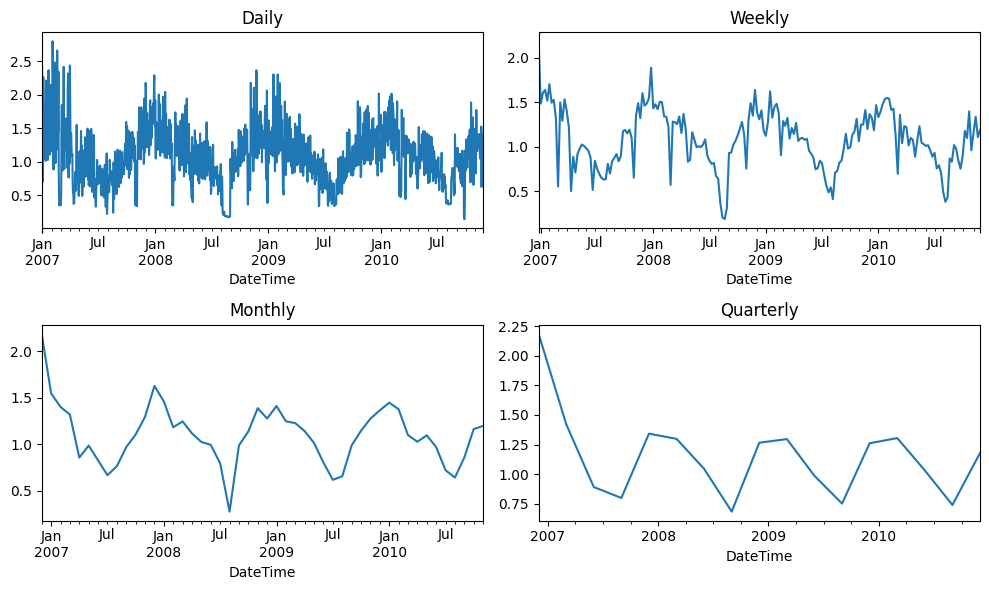

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
daily.plot(y="Global_active_power", ax=axes[0,0], title="Daily")
weekly.plot(y="Global_active_power", ax=axes[0,1], title="Weekly")
monthly.plot(y="Global_active_power", ax=axes[1,0], title="Monthly")
quarterly.plot(y="Global_active_power", ax=axes[1,1], title="Quarterly")
plt.tight_layout()
plt.plot()

## Decompose Trend and Seasonality  

In [8]:
def decompose(time_period, period):
    decomposition = sm.tsa.seasonal_decompose(time_period, model='additive', period=period)
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))
    axes[0].plot(decomposition.trend)
    axes[0].set_title("Trend")
    axes[1].plot(decomposition.seasonal)
    axes[1].set_title("Seasonality")
    axes[2].plot(decomposition.resid)
    axes[2].set_title("Residual")
    plt.tight_layout()
    plt.savefig(f"{period}.png")
    plt.plot()
    print(ADF(decomposition.resid.dropna()))
    #print(PhillipsPerron(decomposition.resid.dropna()))
    return decomposition.resid.dropna()

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.796
P-value                         0.000
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


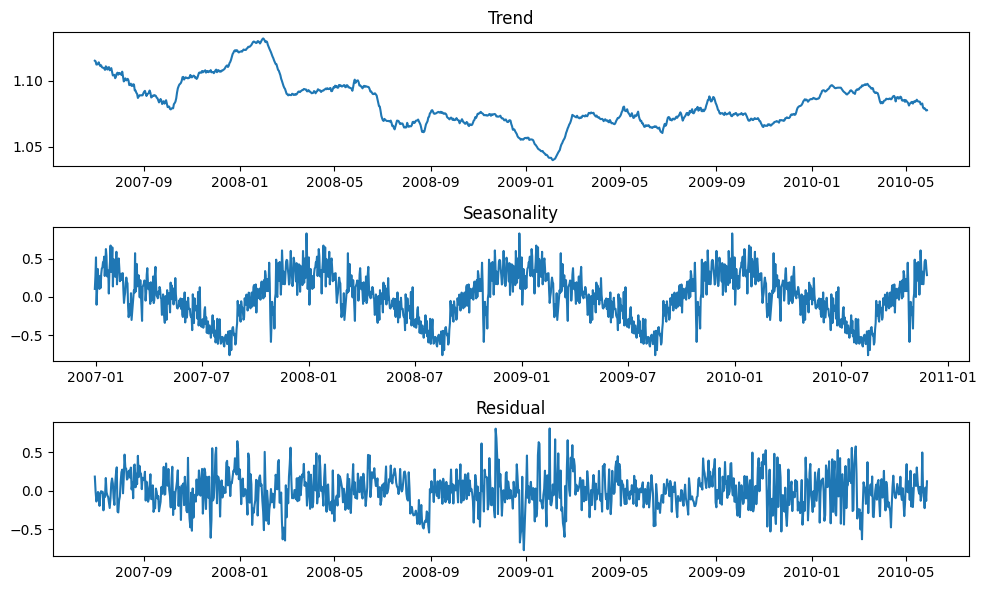

In [9]:
daily_resid = decompose(daily, 365)

In [10]:
len(daily_resid)

1064

   Augmented Dickey-Fuller Results   
Test Statistic                 -6.160
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


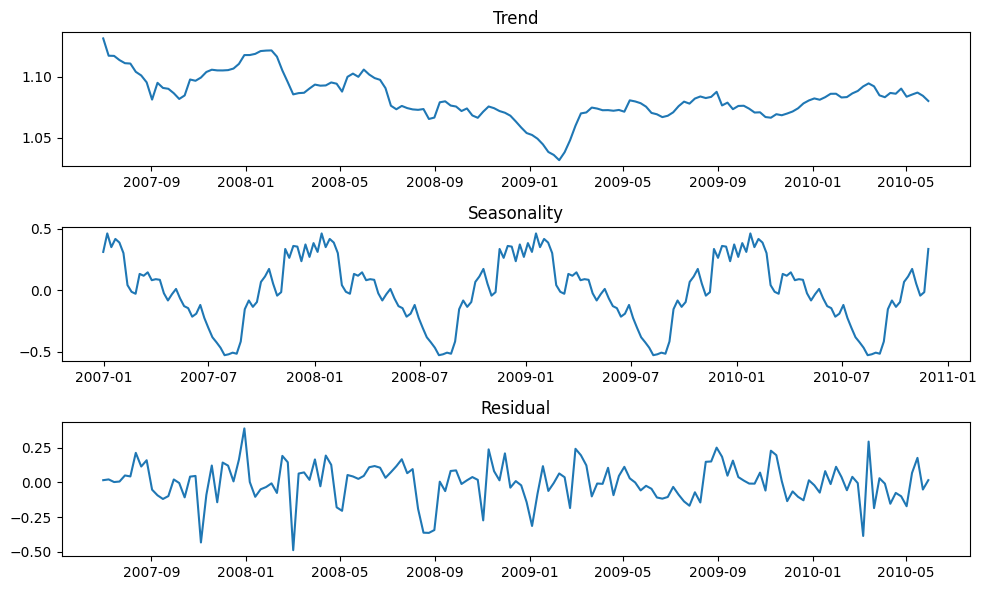

In [11]:
weekly_resid = decompose(weekly, 53)

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.194
P-value                         0.676
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.72 (1%), -2.99 (5%), -2.63 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


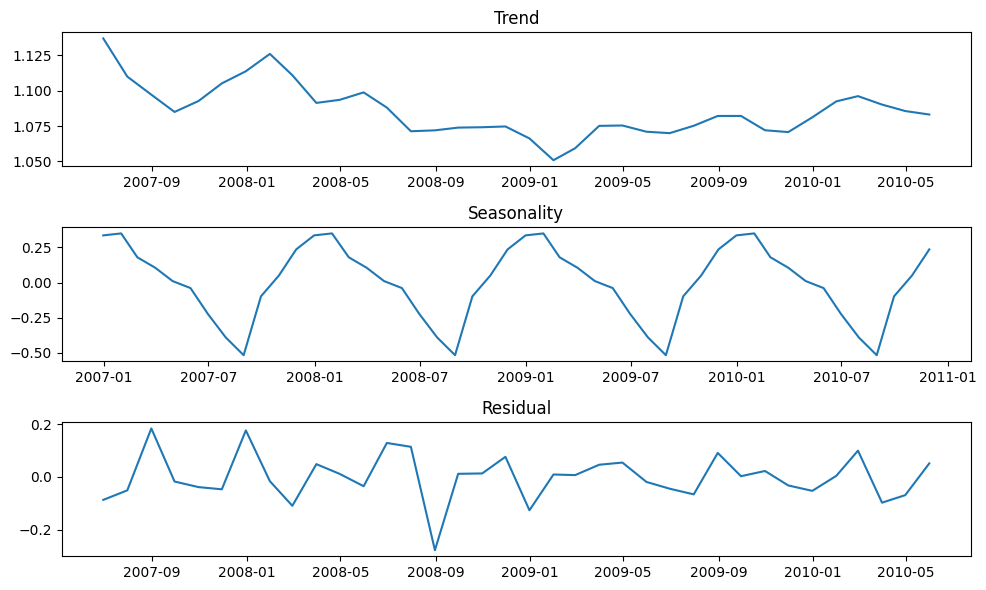

In [12]:
monthly_resid = decompose(monthly, 12)

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.811
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -4.47 (1%), -3.29 (5%), -2.77 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


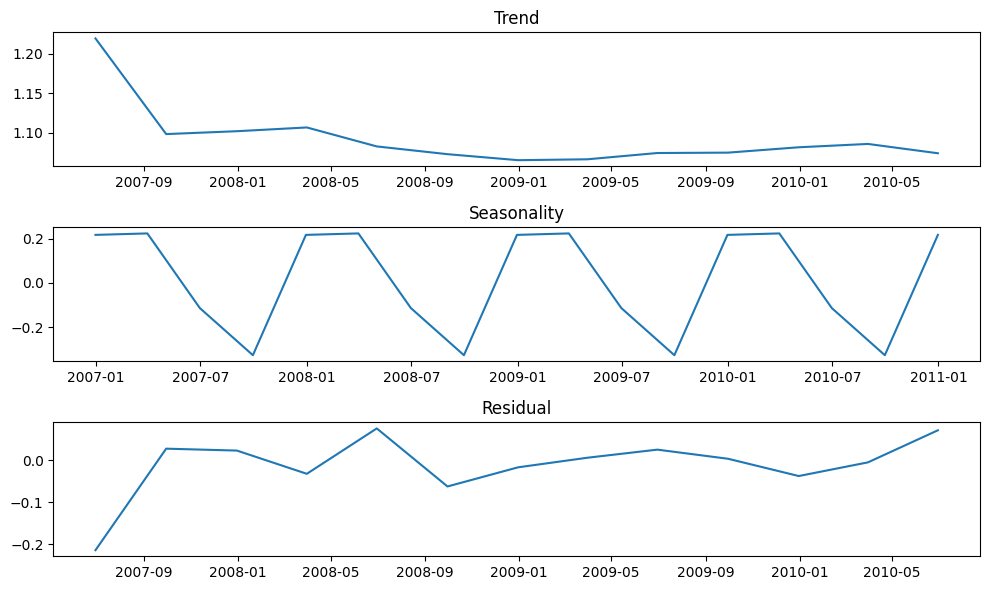

In [13]:
quarterly_resid = decompose(quarterly, 4)

In [14]:
def test_arima(timeseries):
    order_values = [(p, d, q) for p in range(4) for d in range(2) for q in range(4)]
    best_aicc = float('inf')
    best_order = None

    for p in range(4):
        for d in range(2):
            for q in range(4):
                model = ARIMA(timeseries, order=(p, d, q))
                results = model.fit()
                aicc = results.aic
                if aicc < best_aicc:
                    best_aicc = aicc
                    best_order = (p, d, q)
        
    return best_order, best_aicc


In [15]:
print("Best daily ARIMA parameters & AICC:")
test_arima(daily_resid)

Best daily ARIMA parameters & AICC:


((3, 0, 3), -323.041640545289)

In [16]:
print("Best weekly ARIMA parameters & AICC:")
test_arima(weekly_resid)

Best weekly ARIMA parameters & AICC:


((2, 0, 3), -172.03284210513567)

In [17]:
print("Best monthly ARIMA parameters & AICC:")
test_arima(monthly_resid)

Best monthly ARIMA parameters & AICC:


((0, 0, 2), -80.1485249211446)

In [18]:
print("Best quarterly ARIMA parameters & AICC:")
test_arima(quarterly_resid)

Best quarterly ARIMA parameters & AICC:


((0, 0, 1), -31.260912637653263)

# Quality Model Check 

const     0.002700
ar.L1     0.828755
ar.L2    -0.261068
ar.L3     0.174254
ma.L1    -0.544783
ma.L2     0.055526
sigma2    0.046386
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                 1064
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 123.764
Date:                Mon, 22 May 2023   AIC                           -233.528
Time:                        21:37:05   BIC                           -198.739
Sample:                    06-30-2007   HQIC                          -220.345
                         - 05-28-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.013      0.204      0.839      -0

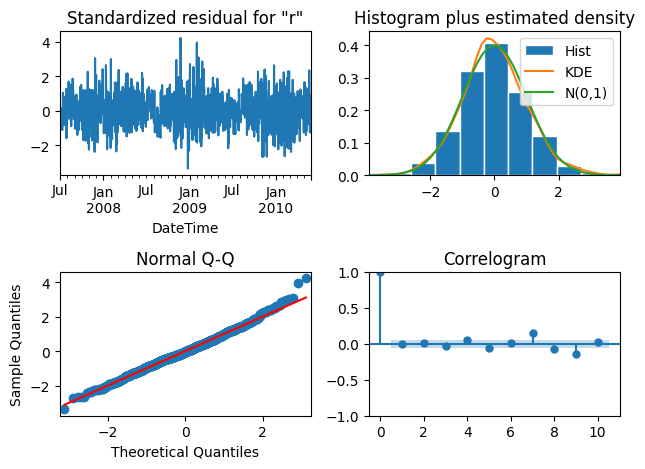

In [19]:
from scipy.stats import shapiro
model = ARIMA(daily_resid, order=(3, 0, 2)).fit()
model.plot_diagnostics()
plt.tight_layout()
plt.savefig("diagnostics_daily.png")
print(model.params)
print(model.summary())
print(shapiro(model.standardized_forecasts_error))


const     0.000081
ar.L1    -0.195370
ar.L2     0.311960
ma.L1     0.408857
ma.L2    -0.260327
sigma2    0.018498
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  153
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  88.105
Date:                Mon, 22 May 2023   AIC                           -164.210
Time:                        21:37:06   BIC                           -146.028
Sample:                    07-01-2007   HQIC                          -156.824
                         - 05-30-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.117e-05      0.016      0.005      0.996      -0.031       0.031
ar

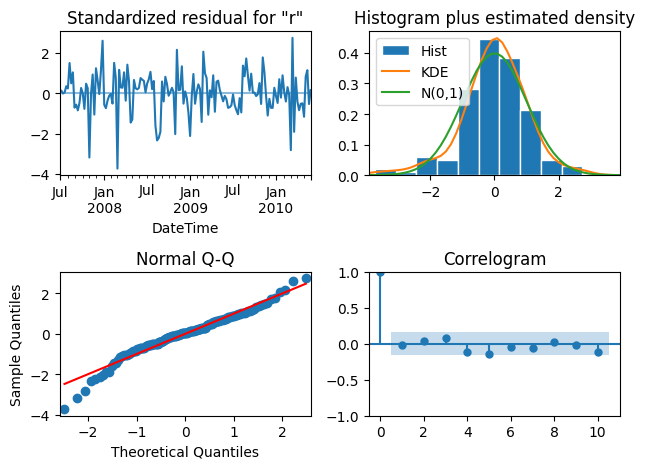

In [20]:
model2 = ARIMA(weekly_resid, order=(2, 0, 2)).fit()
model2.plot_diagnostics()
plt.tight_layout()
plt.savefig("diagnostics_weekly.png")
print(model2.params)
print(model2.summary())
print(shapiro(model2.standardized_forecasts_error))

const     0.000214
ma.L1    -0.793072
sigma2    0.005539
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   36
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  41.947
Date:                Mon, 22 May 2023   AIC                            -77.894
Time:                        21:37:06   BIC                            -73.144
Sample:                    06-30-2007   HQIC                           -76.236
                         - 05-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.004      0.055      0.956      -0.007       0.008
ma.L1         -0.7931      0.113     -7.044      0.000     

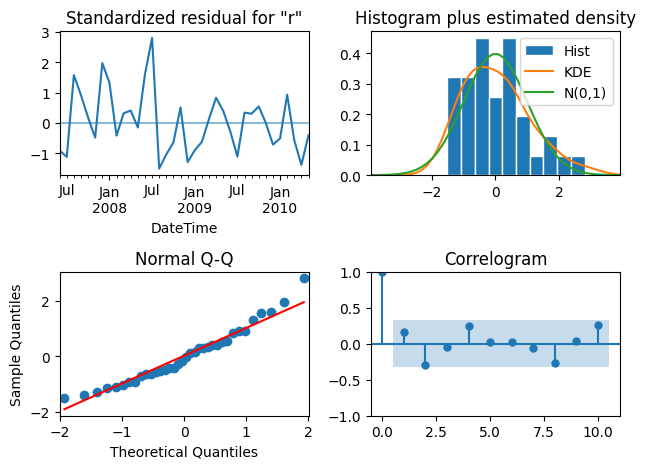

In [21]:
model3 = ARIMA(monthly_resid, order=(0, 0, 1)).fit()
model3.plot_diagnostics()
plt.tight_layout()
plt.savefig("diagnostics_monthly.png")
print(model3.params)
print(model3.summary())
print(shapiro(model3.standardized_forecasts_error))

In [22]:
model4 = ARIMA(quarterly_resid, order=(0, 0, 1)).fit()
print(model4.params)
print(model4.summary())
print(shapiro(model4.standardized_forecasts_error))

const    -0.004072
ma.L1    -0.999661
sigma2    0.002720
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   13
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  18.630
Date:                Mon, 22 May 2023   AIC                            -31.261
Time:                        21:37:06   BIC                            -29.566
Sample:                    06-30-2007   HQIC                           -31.609
                         - 06-30-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.006     -0.664      0.507      -0.016       0.008
ma.L1         -0.9997    380.445     -0.003      0.998    -

## Forecast

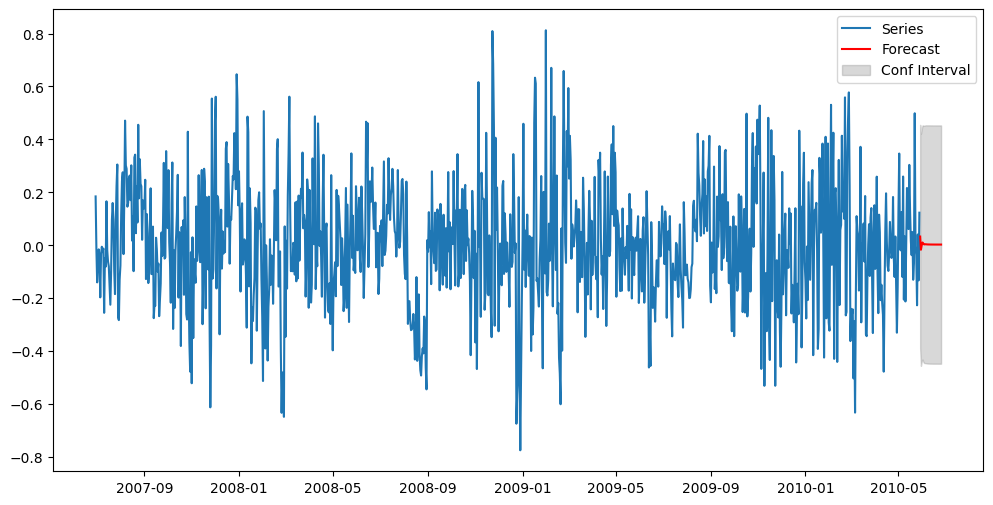

In [23]:
forecast = model.get_forecast(steps=28) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(daily_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.show()

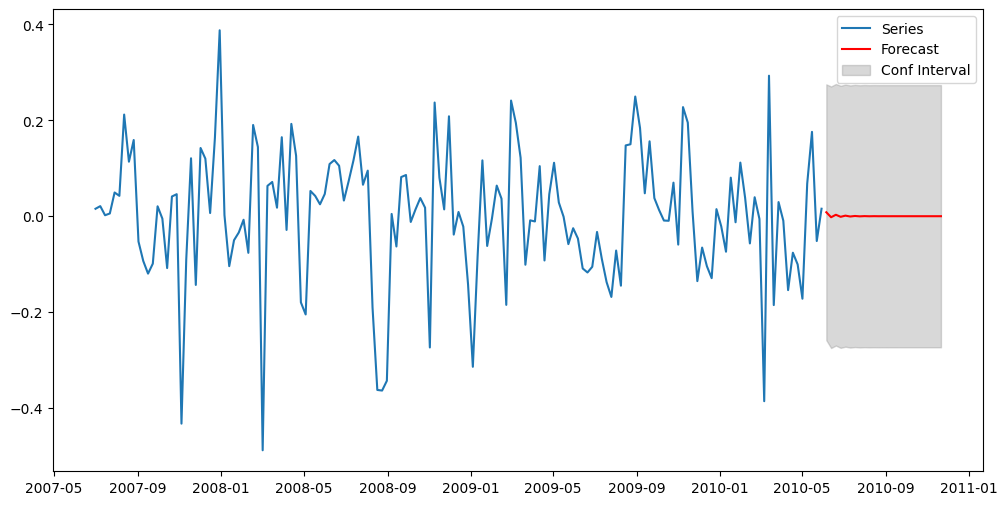

In [24]:
forecast = model2.get_forecast(steps=25) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(weekly_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.show()

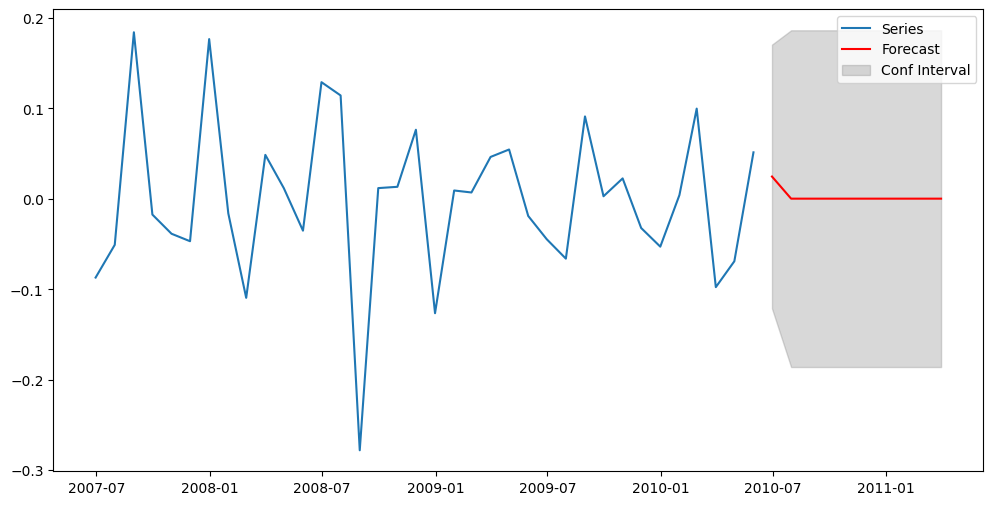

In [25]:
forecast = model3.get_forecast(steps=10) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(monthly_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.show()

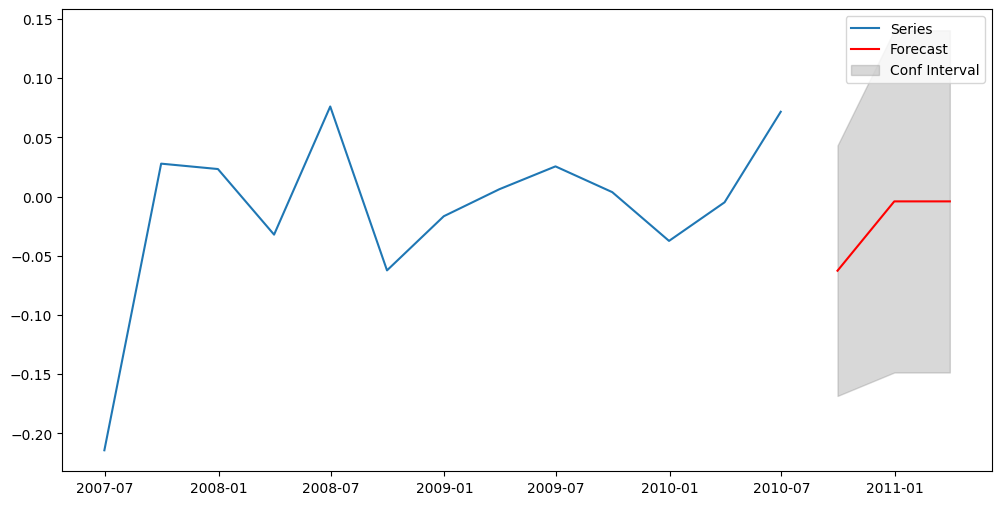

In [26]:
forecast = model4.get_forecast(steps=3) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(quarterly_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.show()

# To check

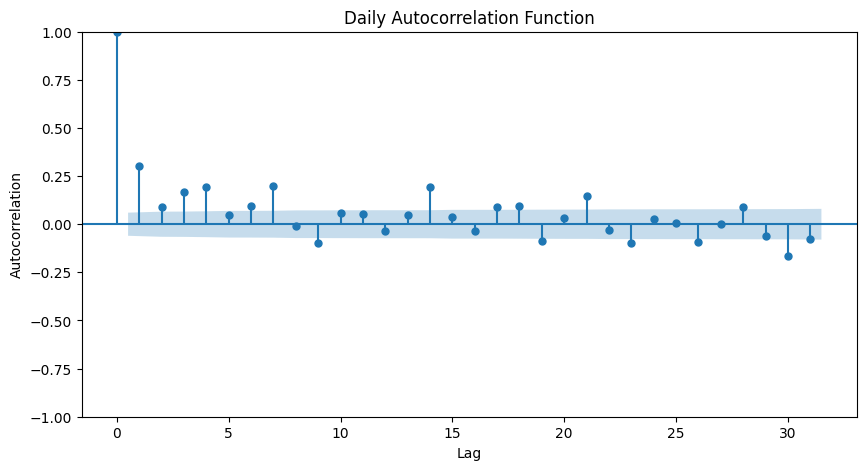

the number of values is: 1064


In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(daily_resid, ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Daily Autocorrelation Function')
plt.show()
daily_count=len(daily_resid)
print('the number of values is:',daily_count)

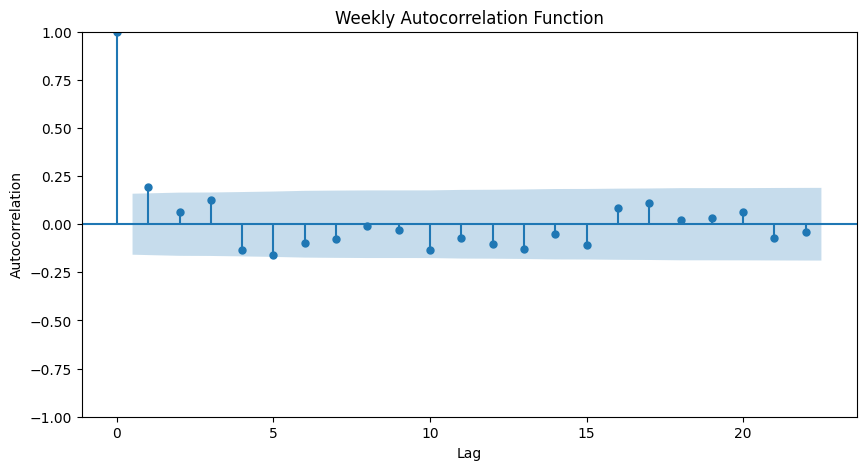

the number of values is: 153


In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(weekly_resid, ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Weekly Autocorrelation Function')
plt.show()

weekly_count=len(weekly_resid)
print('the number of values is:',weekly_count)



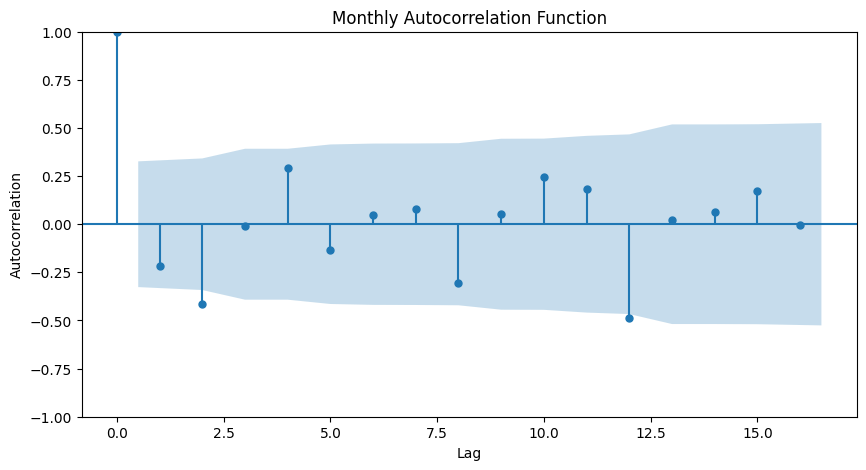

the number of values is: 36


In [29]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(monthly_resid, ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Monthly Autocorrelation Function')
plt.show()
monthly_count=len(monthly_resid)
print('the number of values is:',monthly_count)

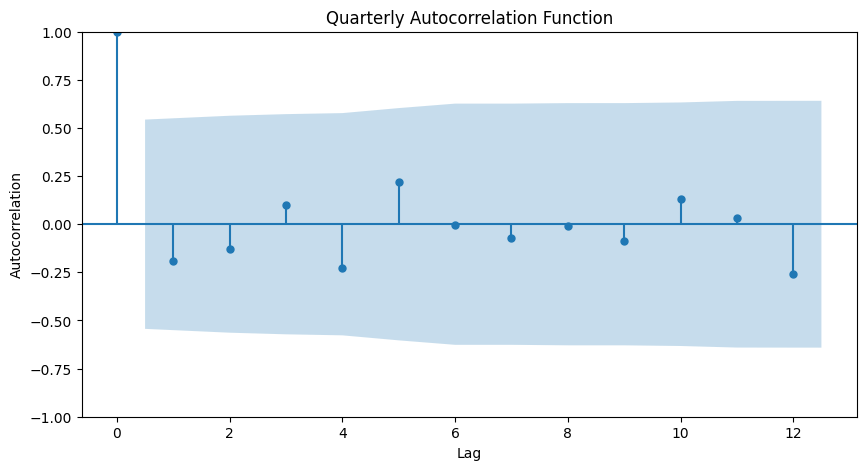

the number of values is: 13


In [30]:

fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(quarterly_resid, ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Quarterly Autocorrelation Function')
plt.show()
quarterly_count=len(quarterly_resid)
print('the number of values is:', quarterly_count)

In [31]:
len(daily_resid)/365

2.915068493150685